In [1]:
import os
import random
import shutil
import time
import warnings
from enum import Enum
import time
from tqdm import tqdm


import numpy as np 
import pandas as pd 

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
from torchvision import transforms
import random
from torchmetrics import CharErrorRate
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pandas as pd
from torchinfo import summary
import matplotlib.pyplot as plt

from transformers import BertGenerationConfig

from IPython.display import clear_output
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

In [3]:
BATCH_SIZE = 8

In [4]:
df = pd.read_csv('/kaggle/input/vk-made-ocr/train_labels.csv')
df[df.Expected.isna()]

,Id,Expected
7185,7186.jpg,NaN
8000,8001.jpg,NaN
8223,8224.jpg,NaN
9104,9105.jpg,NaN
27861,27862.jpg,NaN
38399,38400.jpg,NaN
67450,67451.jpg,NaN
71300,71301.jpg,NaN
73810,73811.jpg,NaN
79307,79308.jpg,NaN


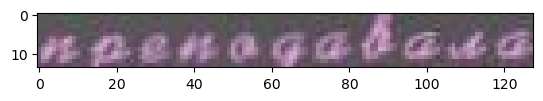

In [5]:
img = Image.open('/kaggle/input/vk-made-ocr/train/train/137.jpg').convert('RGB')
arr = np.asarray(img.getdata()).reshape([img.size[1], img.size[0], 3])
plt.imshow(arr / 255)

In [6]:
MAX_LENGTH = 30

In [7]:
data = pd.read_csv('/kaggle/input/vk-made-ocr/train_labels.csv')
data.dropna(inplace=True)

In [8]:
import itertools
tokens = list(set(itertools.chain(*data.Expected.tolist())))

In [26]:
from transformers.tokenization_utils_base import BatchEncoding
class Tokenizer():
    def __init__(self, tokens):
        self.tokens = tokens
        self.tokens_to_id = {s: i + 3 for i, s in enumerate(tokens)}
        self.vocab_size = len(tokens) + 3
        self.cls_token_id = 2
        self.sep_token_id = 1
        self.pad_token_id = 0
    def __call__(self, labels, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH):
        #batch_length = max(map(len, labels))
        output = torch.zeros((len(labels), max_length + 2), dtype=int)
        for i, lbl in enumerate(labels):
            for j, ch in enumerate(lbl[:max_length]):
                output[i, j + 1] = self.tokens_to_id[ch]
            output[i, 0] = self.cls_token_id
            output[i, j + 2] = self.sep_token_id
        return BatchEncoding({'input_ids': output, 'attention_mask': (output>0).int()})
    def batch_decode(self, batch, skip_special_tokens=True):
        arr = batch.detach().cpu().numpy()
        strings = []
        for a in arr:
            s = ''.join(tokens[i-3] for i in a if 3 <= i)
            strings.append(s)
        return strings
        

In [27]:

# config = BertGenerationConfig.from_pretrained('prajjwal1/bert-mini')
tokenizer = Tokenizer(tokens)
# config.vocab_size = tokenizer.vocab_size
# config

In [11]:
from transformers import (TrOCRProcessor, VisionEncoderDecoderModel, 
                          BertTokenizer, VisionEncoderDecoderModel, BertGenerationDecoder, 
                          BertGenerationConfig, ViTModel)

image_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")

tokenizer = Tokenizer(tokens)

config = BertGenerationConfig.from_pretrained('prajjwal1/bert-mini')

config.vocab_size = tokenizer.vocab_size
config.is_decoder = True
config.add_cross_attention=True
config.decoder_start_token_id = tokenizer.cls_token_id

decoder = BertGenerationDecoder(config)
encoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").encoder

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model=encoder, decoder_model=decoder
)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
train_path = r'/kaggle/input/vk-made-ocr/train/train'
train_labels_path = '/kaggle/input/vk-made-ocr/train_labels.csv'

class DatasetPhoto(Dataset):
    def __init__(self, path, images, labels=None):
        self.images = images            
        self.labels = labels
        self.path = path

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        image = Image.open(os.path.join(self.path, self.images[index])).convert("RGB")
        if self.labels:
            label = self.labels[index]

            return self.images[index], image, label
        else:
            return self.images[index], image
    

data = data[data.Id != '190920.jpg']
train_data, test_data = train_test_split(data, test_size=0.2)

images = train_data.Id.tolist()
labels = train_data.Expected.tolist()
train_dataset = DatasetPhoto(train_path, images, labels)

images = test_data.Id.tolist()
labels = test_data.Expected.tolist()
test_dataset = DatasetPhoto(train_path, images, labels)

def collate_fn(batch):
    names, images, labels = zip(*batch)  
    try:
        pixel_values = image_processor(images, return_tensors="pt").pixel_values
    except ValueError:
        print(names)
    y = tokenizer(labels, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    #print(y.input_ids.shape)
    return pixel_values, y

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        pin_memory=True, collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=True,
        pin_memory=True, collate_fn=collate_fn)

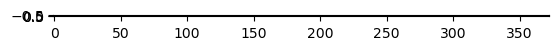

In [13]:
img = Image.open(f'/kaggle/input/vk-made-ocr/train/train/190920.jpg').convert('RGB')
arr = np.asarray(img.getdata()).reshape([img.size[1], img.size[0], 3])
plt.imshow(arr / 255)

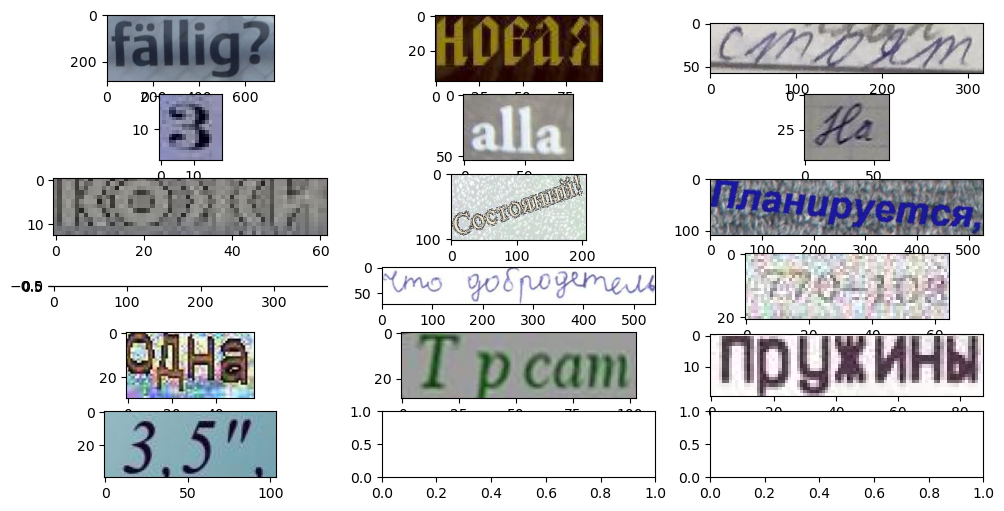

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12, 6))
imgs = []
for ii, img_path in enumerate(('217735.jpg', '87384.jpg', '129952.jpg', 
                               '242110.jpg', '77275.jpg', '55581.jpg', 
                               '180463.jpg', '121252.jpg', '124336.jpg', 
                               '190920.jpg', '53429.jpg', '56005.jpg', '218242.jpg', '96171.jpg', '197577.jpg', '17973.jpg')):
    img = Image.open(f'/kaggle/input/vk-made-ocr/train/train/{img_path}').convert('RGB')
    arr = np.asarray(img.getdata()).reshape([img.size[1], img.size[0], 3])
    ax[ii // 3][ii % 3].imshow(arr / 255)

In [15]:
# debug_iter = iter(train_loader)
# for i, (x, y) in tqdm(enumerate(debug_iter)):
#     pass

In [16]:
DEVICE = 'cuda'


In [17]:
N_EPOCHS = 2

In [18]:
train_losses = []
test_losses = []
test_losses_sm = []
example = ['', '']
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [19]:
def draw():
    clear_output(True)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

    ax[0].plot(train_losses, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')

    ax[1].plot(test_losses_sm, label='test loss')
    ax[1].set_xlabel('Batch')
    ax[1].set_title('test loss')

    ax[2].text(0.3, 0.5, "True:" + example[0], va='bottom') ## будет сверху,
    ax[2].text(0.7, 0.5, example[1], va='top')
    plt.legend()

    plt.show()

In [20]:
model.to(DEVICE)
#model = nn.DataParallel(model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

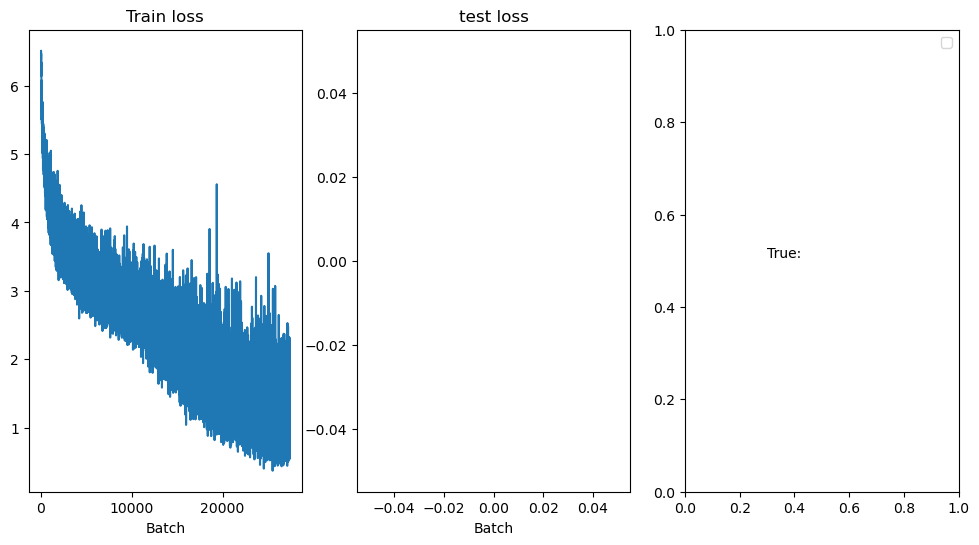

27598it [6:00:36,  1.28it/s]
199it [01:24,  2.35it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
199it [01:26,  2.30it/s]


TypeError: Tokenizer.batch_decode() got an unexpected keyword argument 'skip_special_tokens'

In [21]:

for epoch in range(1, 1 + N_EPOCHS):
    
    model.train()
    for i, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        labels = y.input_ids[:, 1:].clone().detach()
        labels[labels == 0] = -100
        #print(x.input_ids.shape, y.input_ids.shape, labels.shape)
        loss = model(
            pixel_values=x,
            labels=labels,
            decoder_attention_mask=y.attention_mask[:, 1:].clone().detach(),
            return_dict=True,
            use_cache=False
        ).loss
        # делаем шаг градиентного спуска
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        train_losses.append(loss.item())
        
        if (i+1)%200==0:
            clear_output(True)
            draw()
        torch.cuda.empty_cache()
    examples = []
    model.eval()
    for i, (x, y) in tqdm(enumerate(test_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        labels = y.input_ids[:, 1:].clone().detach()
        labels[labels == 0] = -100
        #print(x.input_ids.shape, y.input_ids.shape, labels.shape)
        loss = model(
            pixel_values=x,
            labels=labels,
            decoder_attention_mask=y.attention_mask[:, 1:].clone().detach(),
            return_dict=True,
            use_cache=False
        ).loss
        
        test_losses.append(loss.item())
        if i > 200:
            test_losses_sm.extend(pd.Series(losses).ewm(200).mean()[200:].tolist())
        if (i + 1)%200==0:
            
            predictions = tokenizer.batch_decode(model.generate(x), skip_special_tokens=True)
            true_labels = tokenizer.batch_decode(y.input_ids, skip_special_tokens=True)
            examples.extend(zip(true_labels, predictions))
            
            clear_output(True)
            draw()
        
        torch.cuda.empty_cache()
    model.save_pretrained(os.path.join('/kaggle/working', f'model_{epoch}ep'))
    example = random.sample(examples, 1)[0]

In [28]:
predictions = tokenizer.batch_decode(model.generate(x), skip_special_tokens=True)
true_labels = tokenizer.batch_decode(y.input_ids, skip_special_tokens=True)

In [ ]:
example = random.sample(examples, 1)[0]

In [22]:
model.save_pretrained(os.path.join('/kaggle/working', f'model_{epoch}ep'))

In [ ]:
for i, (x, y) in tqdm(enumerate(test_loader)):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    labels = y.input_ids[:, 1:].clone().detach()
    labels[labels == 0] = -100
    #print(x.input_ids.shape, y.input_ids.shape, labels.shape)
    loss = model(
        pixel_values=x,
        labels=labels,
        decoder_attention_mask=y.attention_mask[:, 1:].clone().detach(),
        return_dict=True,
        use_cache=False
    ).loss

    test_losses.append(loss.item())
    if (i + 1)%200==0:

        predictions = tokenizer.batch_decode(model.generate(x), skip_special_tokens=True)
        true_labels = tokenizer.batch_decode(y.input_ids, skip_special_tokens=True)
        examples.extend(zip(true_labels, predictions))

        clear_output(True)
        draw()
    torch.cuda.empty_cache()
    break

In [ ]:
for true, pred in zip(predictions, true_labels):
    print(true)
    print(pred)
    print('---------------------------------------------------\n')

In [31]:
pred_data = DatasetPhoto('/kaggle/input/vk-made-ocr/test/test', os.listdir('/kaggle/input/vk-made-ocr/test/test'))

def pred_collate_fn(batch):  
    names, images = zip(*batch)
    pixel_values = image_processor(images, return_tensors="pt").pixel_values
    return names, pixel_values

pred_loader = torch.utils.data.DataLoader(
        pred_data, batch_size=BATCH_SIZE, shuffle=True,
        pin_memory=True, collate_fn=pred_collate_fn)

dl = iter(pred_loader)
batch = next(dl)

generated_ids = model.generate(batch[1].to(DEVICE))
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [36]:
df = pd.DataFrame()
model.eval()
for i, batch in tqdm(enumerate(pred_loader)):
    generated_ids = model.generate(batch[1].to(DEVICE))
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    
    df = pd.concat(
        (df, pd.DataFrame({'Id': batch[0], 'Predicted': generated_text})),
        axis=0
    )
    

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

In [37]:
df.to_csv('/kaggle/working/subm0.csv', index=False)

In [29]:
true_labels

['года',
 'осколкам',
 'медка',
 'Netherlands',
 'Mitch',
 'племянников,',
 '2%',
 'РОЗОВОЕ']

In [30]:
predictions

['АРЕЛА',
 'ослалкат,',
 'мелука',
 'Netteriinas',
 'ARANI',
 'племянников,',
 '2-19',
 'РОЗОВОЕ']